### Q-러닝 엘리베이터 모델

Episode 1: Total Reward = -2830
Episode 2: Total Reward = -59
Episode 3: Total Reward = -161
Episode 4: Total Reward = -938
Episode 5: Total Reward = -2376
Episode 6: Total Reward = -700
Episode 7: Total Reward = -1779
Episode 8: Total Reward = -2701
Episode 9: Total Reward = -933
Episode 10: Total Reward = -1924
Episode 11: Total Reward = -1265
Episode 12: Total Reward = -2071
Episode 13: Total Reward = -651
Episode 14: Total Reward = -739
Episode 15: Total Reward = -2096
Episode 16: Total Reward = -2719
Episode 17: Total Reward = -53
Episode 18: Total Reward = -56
Episode 19: Total Reward = -2049
Episode 20: Total Reward = -3049
Episode 21: Total Reward = -1777
Episode 22: Total Reward = 0
Episode 23: Total Reward = -176
Episode 24: Total Reward = -1602
Episode 25: Total Reward = 0
Episode 26: Total Reward = -482
Episode 27: Total Reward = -1289
Episode 28: Total Reward = -2804
Episode 29: Total Reward = -945
Episode 30: Total Reward = -1261
Episode 31: Total Reward = -2873
Episode 3

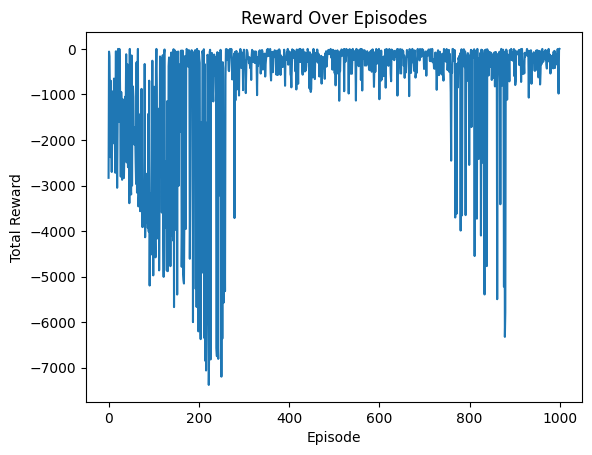

학습 완료
최적 Q 테이블:
[[[ -62.96983519  -51.03905448  -59.89072576  -81.46966927  -58.5657458 ]
  [ -54.67415961  -55.75235091  -58.12826177  -53.95272385  -51.30207264]
  [ -53.50457714  -58.7297377   -54.92081525  -50.57218506  -53.78649179]
  [-177.87992231 -141.94808537 -195.04389795  -58.64347763 -161.17921547]
  [ -60.782379    -64.79589242  -64.27957985  -69.28208447  -47.79038126]]

 [[ -60.86144727  -66.17043935  -70.84557276  -85.15522445  -51.76646707]
  [ -62.75193659  -56.65048942  -51.39363178  -52.09497494  -52.54732229]
  [ -50.92425365  -53.4419748   -57.55613244  -52.20525113  -54.1767372 ]
  [ -58.50657808 -101.43701472 -186.22558725 -151.26870597 -182.53754531]
  [ -80.48367644  -60.32655697  -56.0822177   -47.92377991  -76.37091298]]

 [[ -50.28008228  -64.54893609  -59.1509893   -62.85096801  -80.96460015]
  [ -51.55785777  -60.64446736  -52.01813861  -57.23549327  -55.38528863]
  [ -57.46486938  -56.20844215  -58.24943708  -55.7077204   -50.00816427]
  [-176.35177246  

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt


class ElevatorEnv:
    def __init__(self, num_floors=5, rw=-1):
        self.num_floors = num_floors
        self.rw = rw  # 대기 및 탑승 중인 승객의 보상(기본 음수)
        self.reset()

    def reset(self):
        self.current_floor = np.random.randint(self.num_floors)
        self.target_floor = np.random.randint(self.num_floors)
        self.last_direction = 0  # 이전 방향
        self.current_direction = 0  # 현재 방향
        self.state_info = np.random.choice([0, 1], (self.num_floors, 3), p=[0.8, 0.2])
        self.passenger_wait_times = np.zeros(self.num_floors)
        return self._get_observation()

    def _get_observation(self):
        return (
            self.current_floor,
            self.target_floor,
            self.last_direction,
            self.current_direction,
            self.state_info.flatten(),
        )

    def step(self, action):
        self.last_direction = self.current_direction
        self.current_direction = np.sign(action - self.current_floor)
        self.current_floor = action

        reward = self._calculate_reward()

        self.state_info[self.current_floor, :] = 0
        self.passenger_wait_times[self.current_floor] = 0

        self.passenger_wait_times += self.state_info[:, 0] + self.state_info[:, 1] + self.state_info[:, 2]

        for i in range(self.num_floors):
            if np.random.rand() < 0.2:
                self.state_info[i, np.random.randint(3)] = 1

        done = np.sum(self.state_info) == 0
        info = {}
        return self._get_observation(), reward, done, info

    def _calculate_reward(self):
        waiting_passengers = int(self.passenger_wait_times.sum())
        reward = self.rw * waiting_passengers
        return reward


class QLearningElevatorAgent:
    def __init__(self, num_floors, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.num_floors = num_floors
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((num_floors, num_floors, num_floors))

    def choose_action(self, state):
        current_floor, target_floor, _, _, _ = state
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.num_floors - 1)
        else:
            return np.argmax(self.q_table[current_floor, target_floor])

    def update_q_value(self, state, action, reward, next_state):
        current_floor, target_floor, _, _, _ = state
        next_floor, next_target_floor, _, _, _ = next_state

        best_next_action = np.max(self.q_table[next_floor, next_target_floor])
        td_target = reward + self.gamma * best_next_action
        td_error = td_target - self.q_table[current_floor, target_floor, action]
        self.q_table[current_floor, target_floor, action] += self.alpha * td_error


# 학습 및 보상 추적 실행
def train_elevator_agent(episodes=1000, num_floors=5):
    env = ElevatorEnv(num_floors=num_floors)
    agent = QLearningElevatorAgent(num_floors=num_floors)

    rewards_per_episode = []  # 각 에피소드별 보상을 저장

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for t in range(200):  # 한 에피소드 최대 200 타임스텝
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update_q_value(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if done:
                break

        rewards_per_episode.append(total_reward)  # 에피소드의 총 보상 저장
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    # 보상 시각화
    plt.plot(rewards_per_episode)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward Over Episodes")
    plt.show()

    # 학습 종료 메시지
    print("학습 완료")
    print("최적 Q 테이블:")
    print(agent.q_table)

    return rewards_per_episode


# 학습 실행
rewards = train_elevator_agent(episodes=1000, num_floors=5)
